# Experiment

## Bike Sharing Dataset 

### Problem Description

Course project. <br>
Couse: [Big Data Analytics with R and Microsoft Azure Machine Learning 2.0](https://www.datascienceacademy.com.br/course?courseid=analise-de-dados-com-r) by [Data Science Academy](www.datascienceacademy.com.br)


Dataset source: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Abstract: This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.



### Data Information:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered



## Main Objective

This experiment aims to create a predictive model for estimate the demand for bike rentals.

The objective is to predict the value of the variable cnt (count) representing the amount of rented bikes within a specific time and whose range is 1-977.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats

### Default paths

In [2]:
PATH_RAW_DATA = '../data/raw'

### Dataset

In [3]:
bikes = pd.read_csv(PATH_RAW_DATA+'/bikes.csv')
print(bikes.shape)

bikes.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We have 17379 data point and 17 columns/features

In [4]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
# Checking NA values
bikes.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Good, we don`t have any missing data

# EDA - Exploratory Data Analysis

Let`s see how the data is distributed during the week

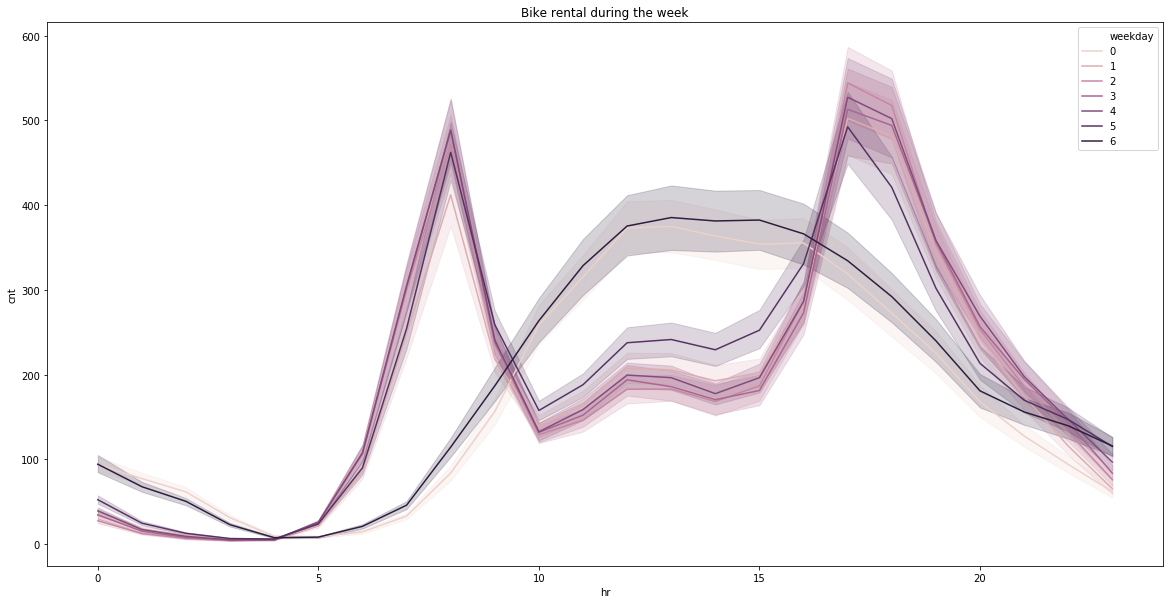

In [6]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=bikes[['hr','cnt', 'weekday']],x='hr', y='cnt',hue='weekday', ax=ax, legend='full')
ax.set(title="Bike rental during the week")

plt.show()

How many of these rentals are casual or registered users?

In [7]:
# but first lets check if the data is consistent

for i in bikes.index:
    if bikes.loc[i, ['casual', 'registered']].sum() != bikes.loc[i, 'cnt']:
        print('Difference identified, index {}'.format(i))

it seems there is nothing wrong with the data...lets plot

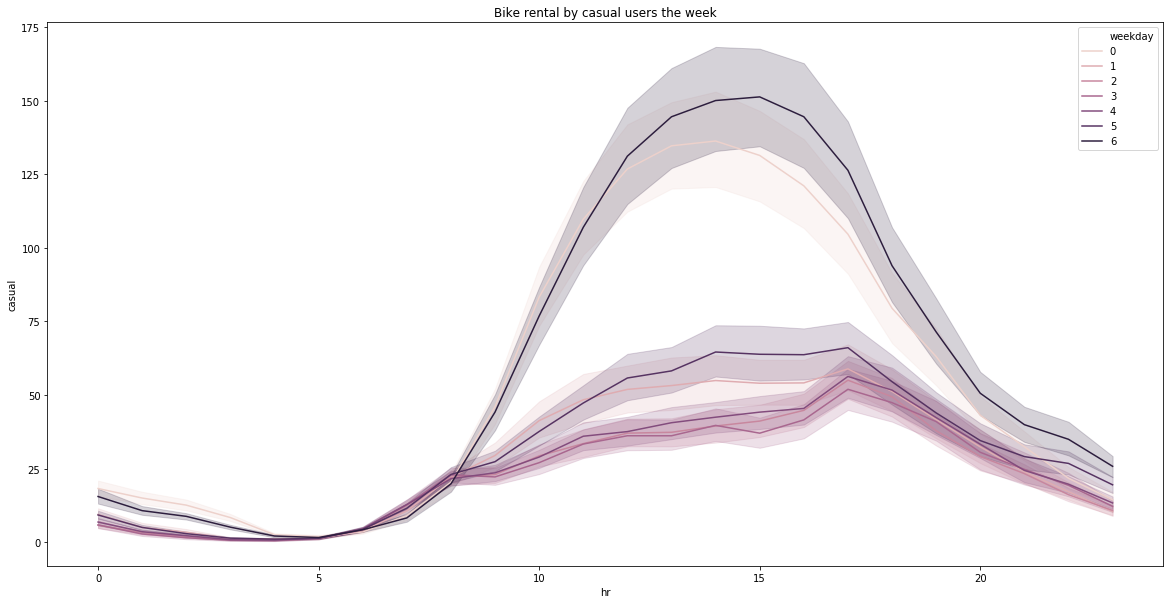

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=bikes[['hr','casual','weekday']], x='hr', y='casual', hue='weekday', ax=ax, legend='full')
ax.set(title="Bike rental by casual users the week")
plt.show()

We can see that casual users seems to use the bikes during afternoon during the all week

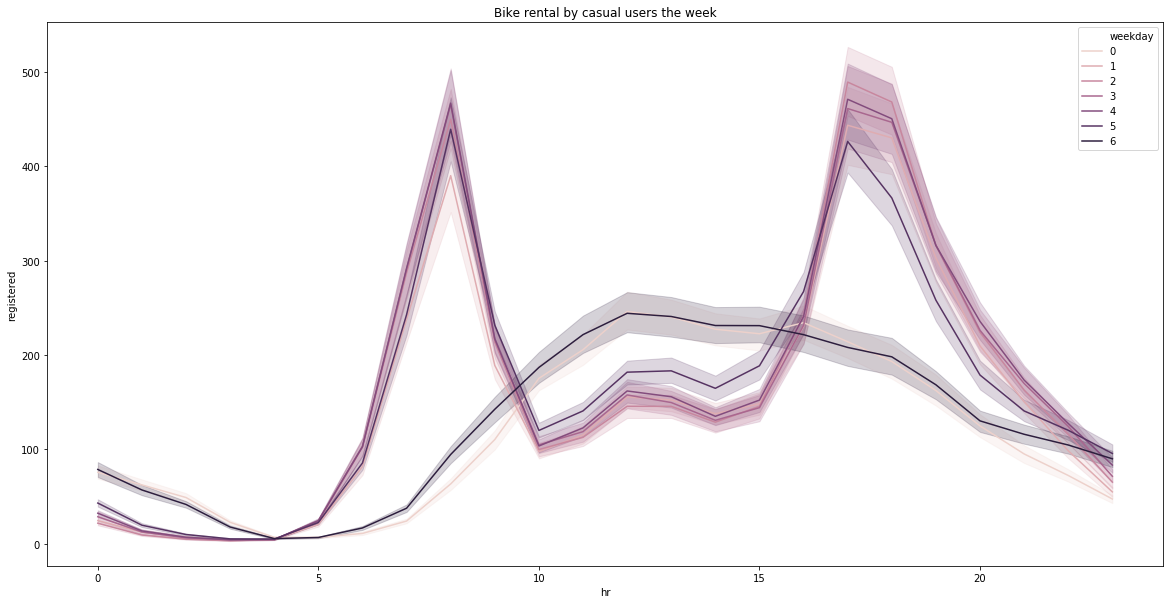

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=bikes[['hr','registered','weekday']], x='hr', y='registered', 
             hue='weekday', ax=ax, legend='full')
ax.set(title="Bike rental by casual users the week")
plt.show()

Registered users are almost equal the first graph

Let`s check how the data behave by weather

First, lets remember the codes from weathersit feature:
    
1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [10]:
bikes.weathersit.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

So, as expected, people stop using the bikes as the weather starts to get worse (snow and rain)

Lets check by season

1:winter <br>
2:spring <br>
3:summer <br>
4:fall

In [11]:
bikes.season.value_counts()

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

[Text(0.5, 1.0, 'Bike rentail by season')]

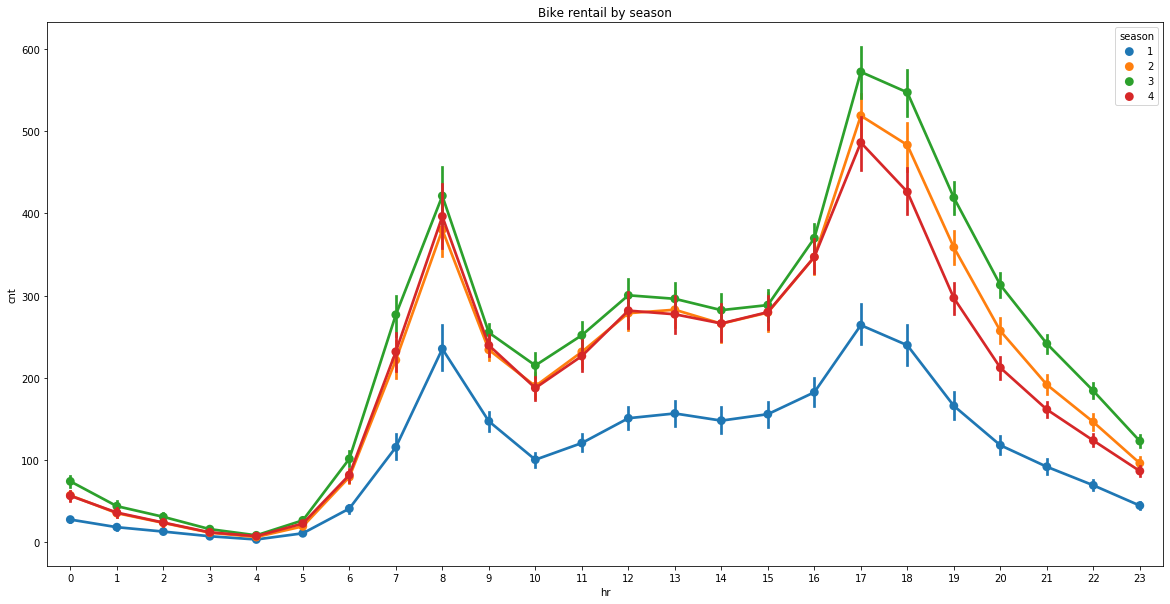

In [12]:
fig, ax = plt.subplots(figsize=(20,10))

sns.pointplot(data=bikes[['hr', 'cnt', 'season']], x='hr', y='cnt', hue='season', ax=ax)

ax.set(title="Bike rentail by season")

As expected (again) people seems to use less during the winter. 
During the night, during fall people tend to use less.
    
    
Lets see the distribution by month  

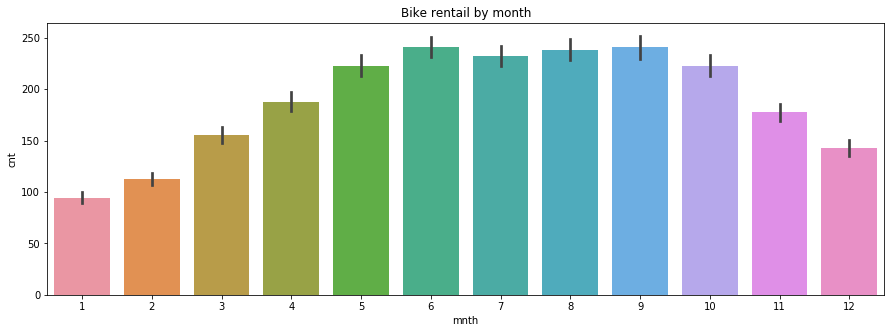

In [13]:
fig, ax = plt.subplots(figsize=(15,5))

sns.barplot(data=bikes[['mnth','cnt']], x='mnth', y='cnt')
ax.set(title="Bike rentail by month")

plt.show()

[Text(0.5, 1.0, 'Bike rentail by day')]

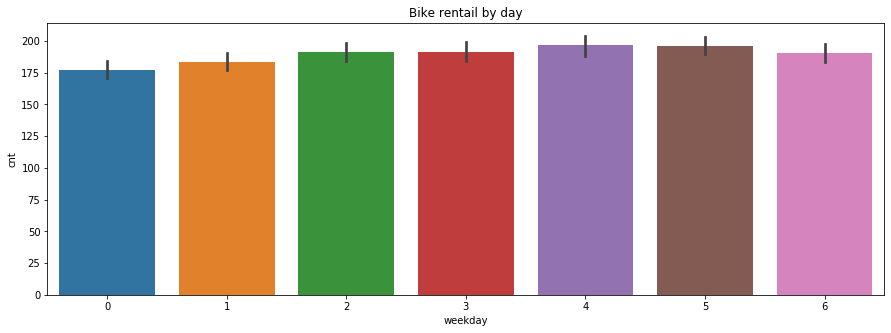

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=bikes[['weekday','cnt']], x='weekday', y='cnt')
ax.set(title="Bike rentail by day")

When we see the data by month its clear that we have some seasonality, but when we look at it by weekday it`s not so different

### Correlation Plot

Lets see which features are more correlated with out target feature (cnt)

In [15]:
#Correlation with our target feature
corr_target = abs(bikes.corr()["cnt"])

#Selecting highly correlated features
relevant_features = corr_target[corr_target>0.5]
relevant_features

casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

Looks like casual and registed are highly correlated with count feature, and it is not a surprise, the sum of both is equal the cnt feature. We are going to remove them both.

Let's visualize it

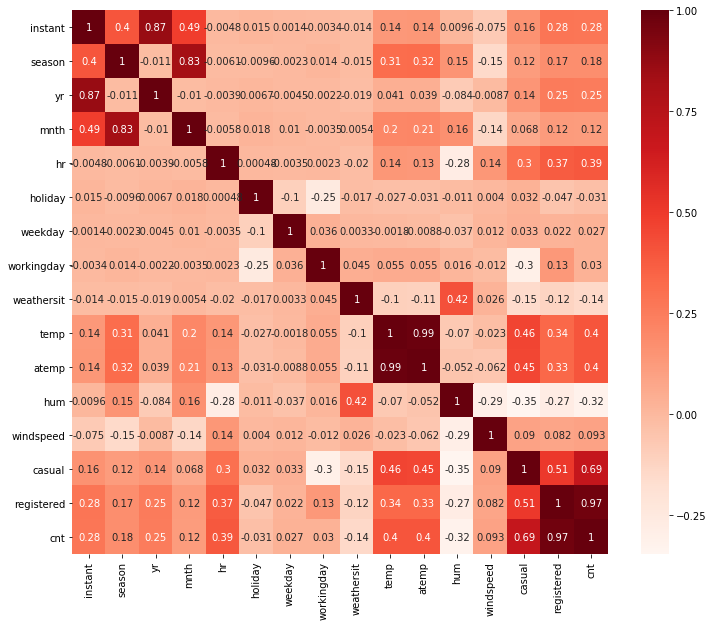

In [16]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = bikes.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


We can see that temp and atemp are 0.99% correlated with each other. Lets remove one of them.

Windspeed and weekday have both a week correlation with cnt, we might remove them from the model, but now lets keep them and see the impact they have during the modeling part.

In [17]:
# We will remove the instant feature as well because its look like a ID row
features_to_be_removed = ['casual', 'registered', 'atemp', 'instant']

Lets check more in details the features that remained

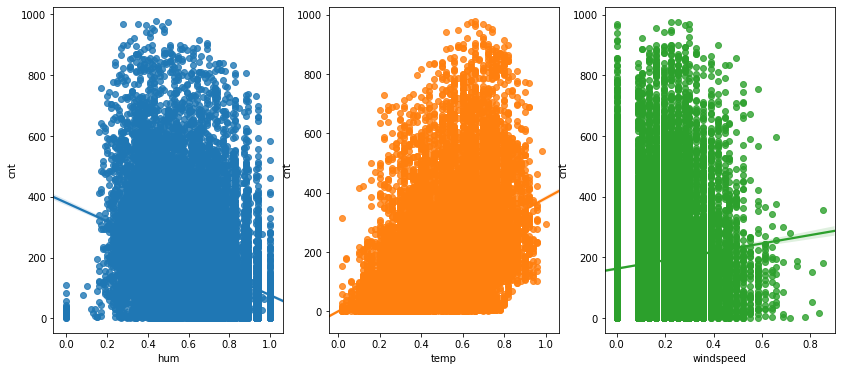

In [18]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(14,6)

#bikes.columns.difference(features_to_be_removed)
sns.regplot(x="hum", y="cnt", data = bikes, ax = ax1)
#plt.show()

sns.regplot(x="temp", y="cnt", data = bikes, ax = ax2)
#plt.show()

sns.regplot(x="windspeed", y="cnt", data = bikes, ax = ax3)
plt.show()

In the windspeed plot we can see that we have a lot of values with 0..lets check them 

In [19]:
len(bikes[bikes['windspeed'] <= 0])

2180

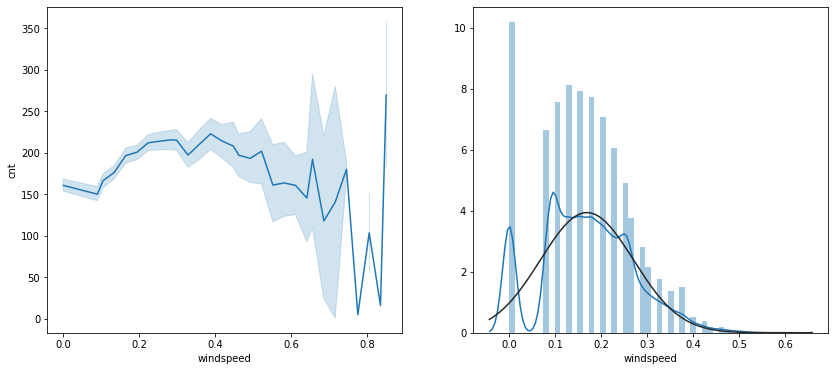

In [20]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.lineplot(data=bikes, x='windspeed', y='cnt', ax=ax1)
sns.distplot(np.log(bikes['windspeed']+1), fit=norm, ax=ax2)
plt.show()

In the data prepation script we will replace the windspeed that have 0 by the mean (0.190)

Let`s check for outliers

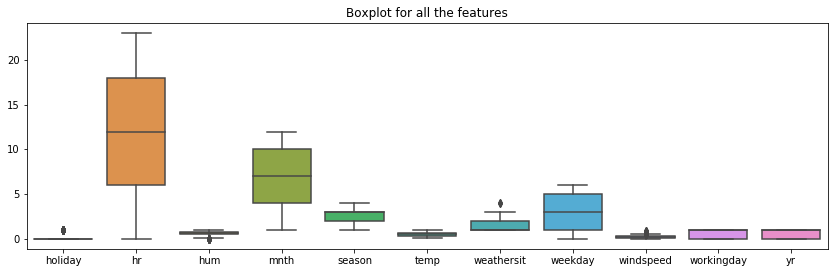

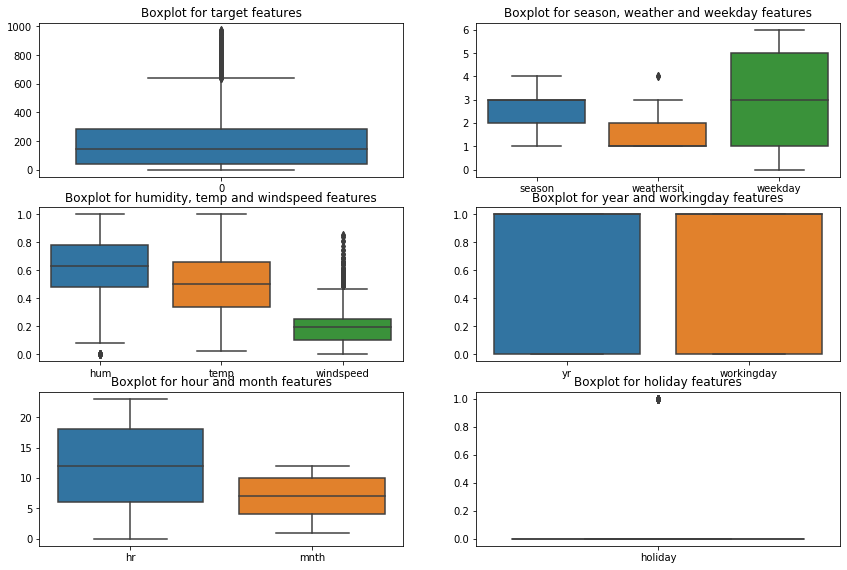

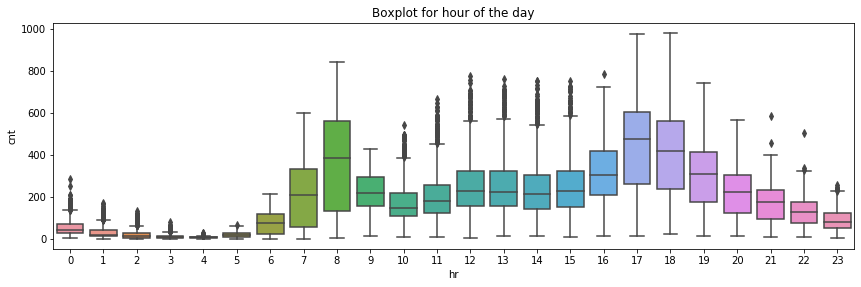

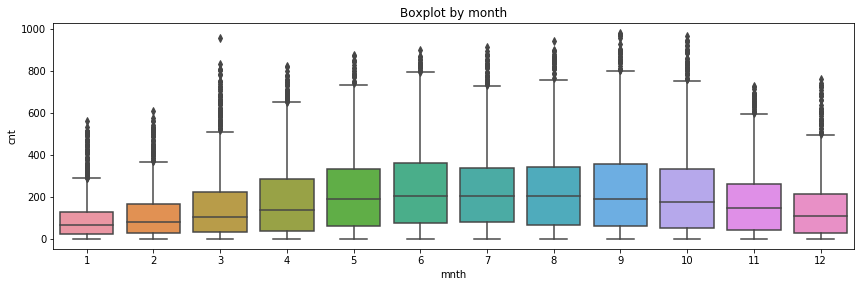

In [21]:
#plt.figure(figsize=(12,10))
gridsize = (9, 4)
fig = plt.figure(figsize=(30, 20))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)

fig = plt.figure(figsize=(30, 30))
ax2 = plt.subplot2grid(gridsize, (2, 0))
ax3 = plt.subplot2grid(gridsize, (2, 1))
ax4 = plt.subplot2grid(gridsize, (3, 0))
ax5 = plt.subplot2grid(gridsize, (3, 1))
ax6 = plt.subplot2grid(gridsize, (4, 0))
ax7 = plt.subplot2grid(gridsize, (4, 1))

fig = plt.figure(figsize=(30, 20))
ax8 = plt.subplot2grid(gridsize, (5, 0), colspan=2, rowspan=2)
fig = plt.figure(figsize=(30, 20))
ax9 = plt.subplot2grid(gridsize, (6, 0), colspan=2, rowspan=2)


sns.boxplot(data=bikes[bikes.columns.difference(features_to_be_removed+['cnt'])], ax=ax1)
ax1.set(title="Boxplot for all the features")

sns.boxplot(data=bikes['cnt'], ax=ax2)
ax2.set(title="Boxplot for target features")

sns.boxplot(data=bikes[['season', 'weathersit', 'weekday']], ax=ax3)
ax3.set(title="Boxplot for season, weather and weekday features")

sns.boxplot(data=bikes[['hum', 'temp', 'windspeed']], ax=ax4)
ax4.set(title="Boxplot for humidity, temp and windspeed features")

sns.boxplot(data=bikes[['yr', 'workingday']], ax=ax5)
ax5.set(title="Boxplot for year and workingday features")

sns.boxplot(data=bikes[['hr', 'mnth']], ax=ax6)
ax6.set(title="Boxplot for hour and month features")

sns.boxplot(data=bikes[['holiday']], ax=ax7)
ax7.set(title="Boxplot for holiday features")

sns.boxplot(x='hr',y='cnt', data =bikes, ax=ax8)
ax8.set(title="Boxplot for hour of the day")

sns.boxplot(x='mnth',y='cnt', data =bikes, ax=ax9)
ax9.set(title="Boxplot by month")


plt.show()

Feature year seem useless...let's remove it 

In [22]:
features_to_be_removed.append('yr')

features_to_be_removed

['casual', 'registered', 'atemp', 'instant', 'yr']

Lets see the in more details the statistics of the features

In [23]:
display(bikes[bikes.columns.difference(features_to_be_removed)].describe())

,cnt,holiday,hr,hum,mnth,season,temp,weathersit,weekday,windspeed,workingday
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,189.463088,0.028770,11.546752,0.627229,6.537775,2.501640,0.496987,1.425283,3.003683,0.190098,0.682721
std,181.387599,0.167165,6.914405,0.192930,3.438776,1.106918,0.192556,0.639357,2.005771,0.122340,0.465431
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.020000,1.000000,0.000000,0.000000,0.000000
25%,40.000000,0.000000,6.000000,0.480000,4.000000,2.000000,0.340000,1.000000,1.000000,0.104500,0.000000
50%,142.000000,0.000000,12.000000,0.630000,7.000000,3.000000,0.500000,1.000000,3.000000,0.194000,1.000000
75%,281.000000,0.000000,18.000000,0.780000,10.000000,3.000000,0.660000,2.000000,5.000000,0.253700,1.000000
max,977.000000,1.000000,23.000000,1.000000,12.000000,4.000000,1.000000,4.000000,6.000000,0.850700,1.000000


It seems that weathersit have an outlier

In [24]:
bikes.weathersit.value_counts()

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64

### Variance With PCA

 Variance explained after PCA : [0.99391565]


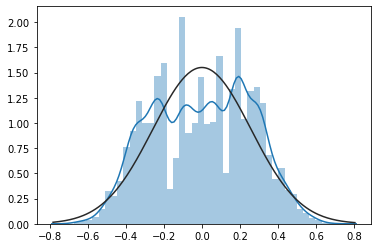

In [25]:
from sklearn.decomposition import PCA

pca=PCA(n_components=1)
pca.fit(bikes[['temp', 'atemp']])

print(f" Variance explained after PCA : {pca.explained_variance_ratio_}")

sns.distplot(pca.fit_transform(bikes[['temp', 'atemp']]), fit=norm)
plt.show()

In the data preparation script we will create a new feature called "temp_PCA" with the PCA of 'temp' and 'atemp'

### Cheking normalization

Lets use the probability plot

----> cnt


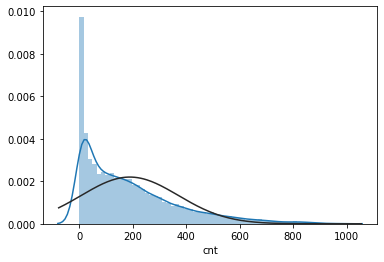

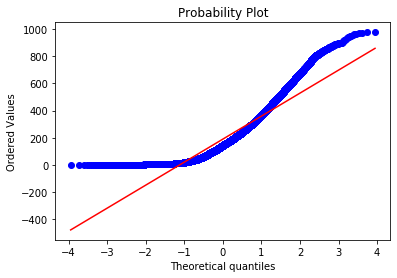

----> holiday


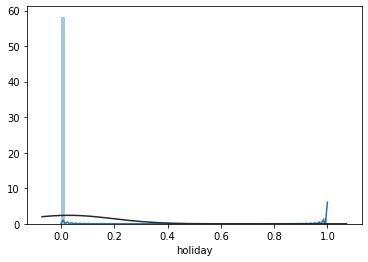

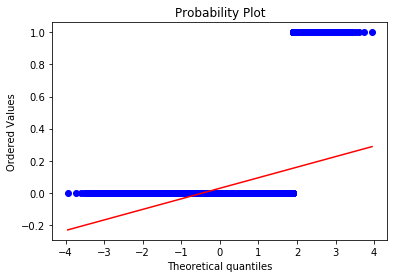

----> hr


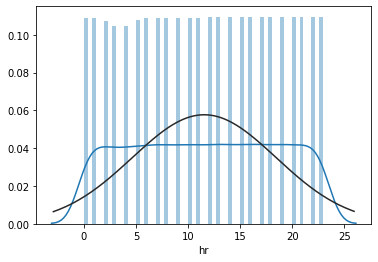

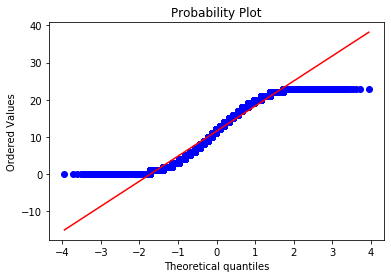

----> hum


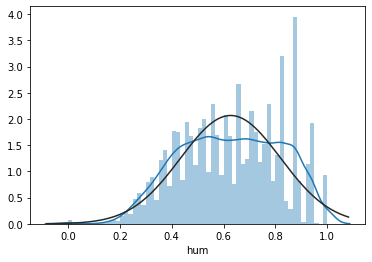

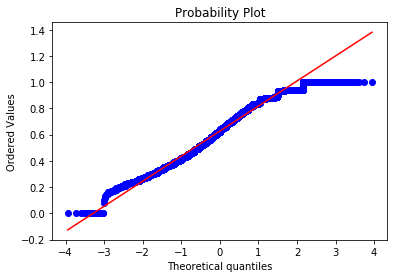

----> mnth


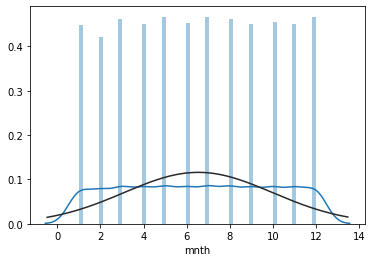

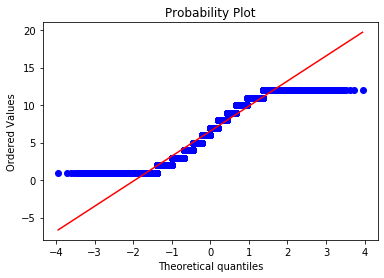

----> season


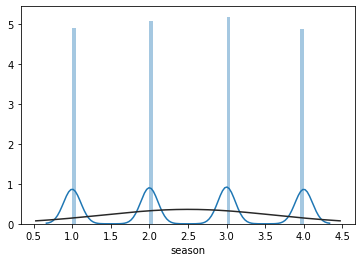

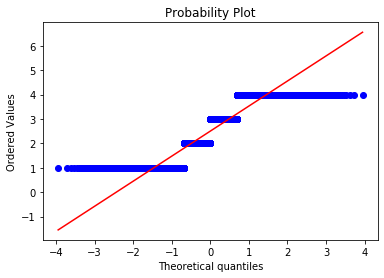

----> temp


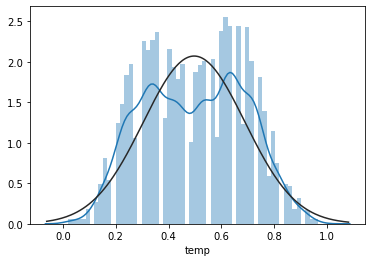

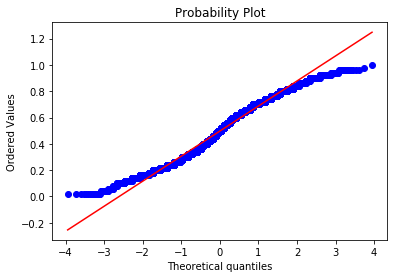

----> weathersit


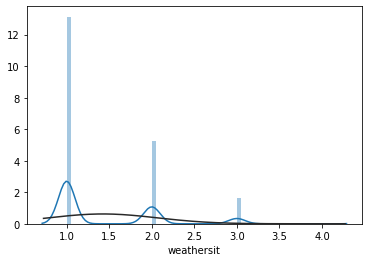

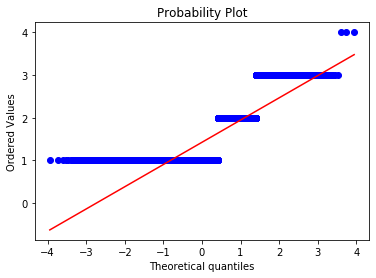

----> weekday


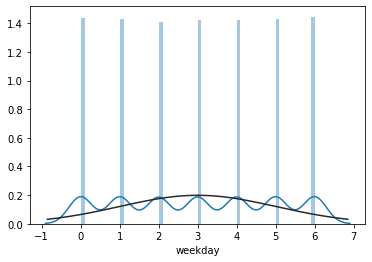

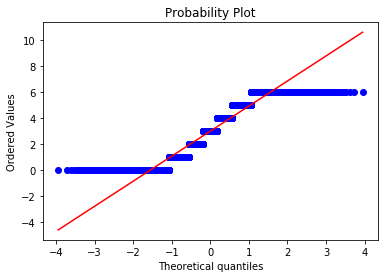

----> windspeed


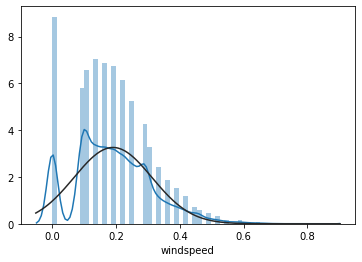

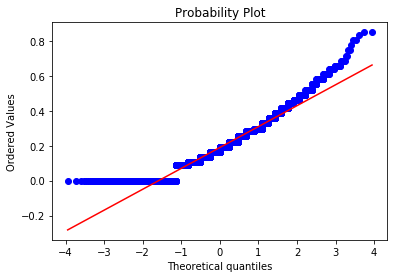

----> workingday


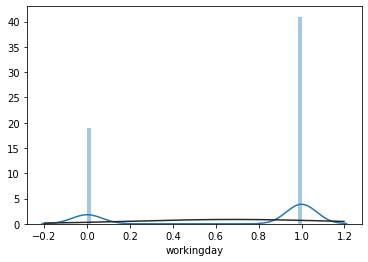

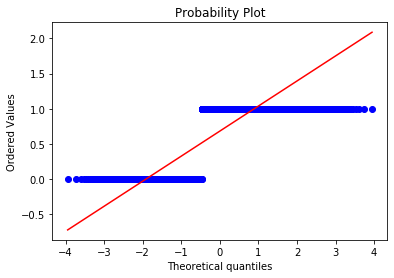

In [26]:
# Histogram and normal probability plot - used to evaluate non-normality of data

for col in bikes[bikes.columns.difference(features_to_be_removed+['dteday'])].columns:
    print('----> {}'.format(col))
    sns.distplot(bikes[col], fit=norm, bins=60, kde=True);
    fig = plt.figure()
    res = stats.probplot(bikes[col], plot=plt)
    plt.show()

Lets save to a list the features that we might normalize:

In [27]:
features_to_normalize = ['cnt', 'hr', 'hum', 'mnth', 'temp', 'windspeed']

With this we have:

In [28]:
# Feature that we are going to ignore
display(features_to_be_removed)

# Feature that we are going to normalize
display(features_to_normalize)

['casual', 'registered', 'atemp', 'instant', 'yr']

['cnt', 'hr', 'hum', 'mnth', 'temp', 'windspeed']